# Weed Detection in Agriculture Field using Unet  and ResNet Architecture

## Library Setup

In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
import torch

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 912.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0+cu121
    Uninstalling torch-2.5.0+cu121:
      Successfully uninstalled torch-2.5.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0+cu121
    Uninstalling torchvision-0.20.0+cu121:
      Successfully uninstalled torchvision-0.20.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.0+cu121
    Uninstalling torchaudio-2.5.0+cu121:
      Successfully uninstalled torchaudio-2.5.0+cu121


In [ ]:
!pip install torchinfo

In [ ]:
from google.colab import drive
from zipfile import ZipFile

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile('/content/drive/MyDrive/extracted_data.zip','r') as zipObj:
  zipObj.extractall('drive/MyDrive/test')

In [ ]:
import torch
import torch.nn as nn# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchinfo import summary

import os
import warnings
warnings.filterwarnings('ignore')
import zipfile

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SPLIT = 0.7
LR = 3e-4
PATH = '/content/drive/MyDrive/test'

## Loading Custom Dataset for UNet

In [ ]:
class UAVDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB") # multi-channel segmentation

        # using random library to ensure image and mask pairs have the same transformations

        if random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        if random() > 0.8:
            image = TF.rotate(image, 30)
            mask = TF.rotate(mask, 30)

        image = TF.to_tensor(image)

        mask = TF.to_tensor(mask)

        return image, mask

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.makedirs('/kaggle/working/saved_model', exist_ok = True) # create library to store saved models

In [ ]:
img_dir = PATH + '/extracted_data/image'
mask_dir = PATH + '/extracted_data/mask'
save_model_path = '/content/drive/MyDrive/test/saved_model'

In [ ]:
img_dir, mask_dir, save_model_path

('/content/drive/MyDrive/test/extracted_data/image',
 '/content/drive/MyDrive/test/extracted_data/mask',
 '/content/drive/MyDrive/test/saved_model')

In [ ]:
data = UAVDataset(img_dir = img_dir, mask_dir = mask_dir)

In [ ]:
data.__len__()

215

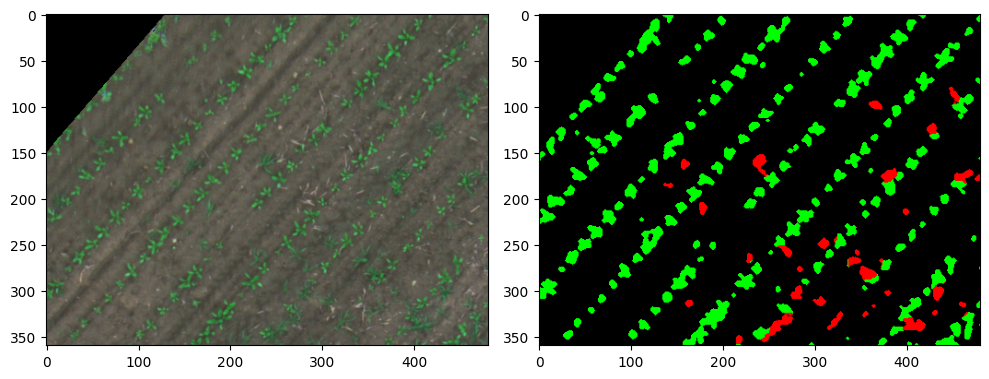

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
image, mask = data[8]
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0))
plt.tight_layout()

In [ ]:
image.shape

torch.Size([3, 360, 480])

In [ ]:
mask.shape

torch.Size([3, 360, 480])

In [ ]:
train_size = int(len(data)*SPLIT)
test_size = len(data) - train_size

trainData, testData = random_split(data, [train_size, test_size])

In [ ]:
len(trainData), len(testData)

(150, 65)

## DataLoader

In [ ]:
trainDL = DataLoader(trainData, batch_size =8 , shuffle = True)
testDL = DataLoader(testData, batch_size = 8, shuffle = True)

In [ ]:
len(trainDL), len(testDL)

(19, 9)

In [ ]:
for batch in trainDL:
    img, mask = batch
    print(img.size())
    print(mask.size())
    break


torch.Size([8, 3, 360, 480])
torch.Size([8, 3, 360, 480])


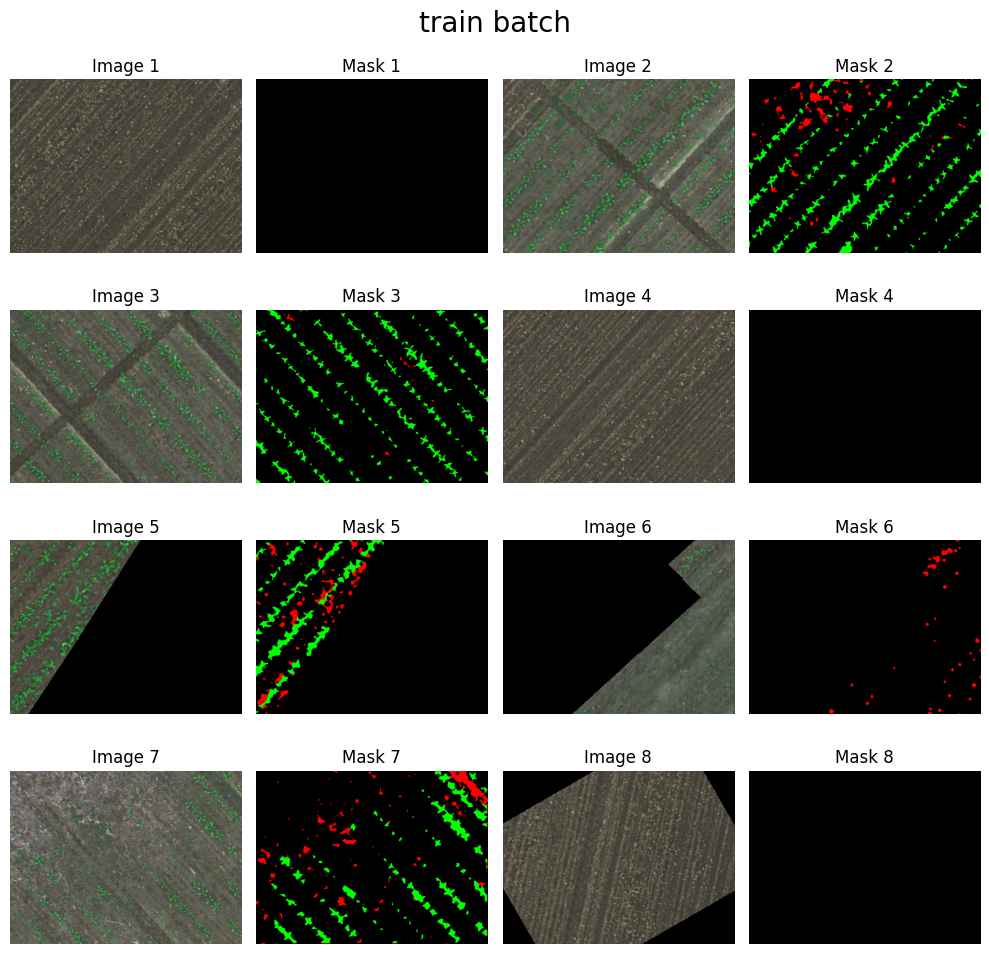

In [ ]:

# plot image, mask pairs of the first training batch
for batch_idx, (images, masks) in enumerate(trainDL):
    if batch_idx == 0:
        fig, axs = plt.subplots(4, 4, figsize=(10,10))
        axs = axs.flatten()
        j = 0
        for i in range(8):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('train batch', size = 20)
        plt.tight_layout()

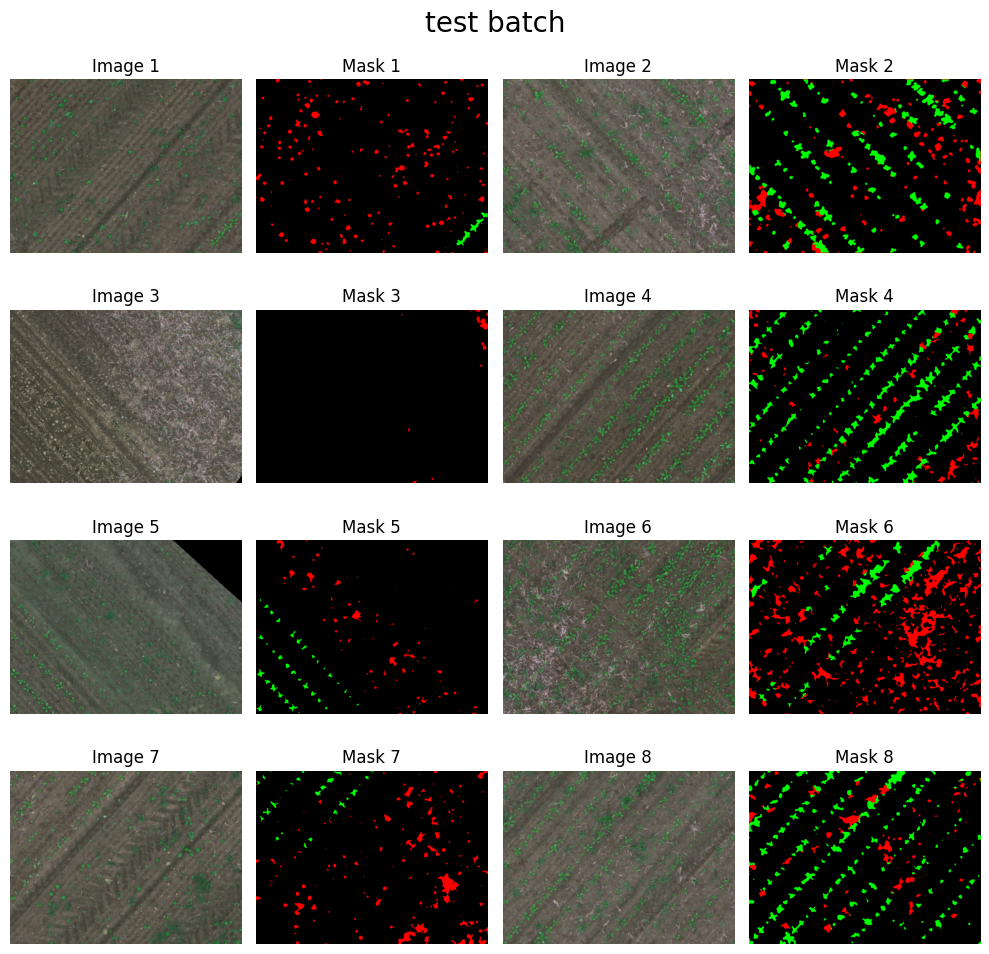

In [ ]:
# plot image, mask pairs of the first test batch
for batch_idx, (images, masks) in enumerate(testDL):

    if batch_idx == 0:

        fig, axs = plt.subplots(4, 4, figsize=(10, 10))
        axs = axs.flatten()
        j=0
        for i in range(8):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('test batch', size = 20)
        plt.tight_layout()

## Metrics

In [ ]:
def pixel_accuracy(pred, target):
  pred = torch.sigmoid(pred)
  pred = (pred > 0.5).float()
  correct = (pred == target).float()
  accuracy = correct.sum() / correct.numel()
  return accuracy.item()

In [ ]:
def dice_coefficient(groundtruth_mask, pred_mask):
    pred_mask = (pred_mask > 0.5).float()
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_sum = torch.sum(pred_mask) + torch.sum(groundtruth_mask)
    dice = torch.mean(2*intersect/total_sum)
    return torch.round(dice*1000)/1000 #round up to 3 decimal places

In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    pred_mask = (pred_mask > 0.5).float()
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = torch.sum(pred_mask)
    precision = torch.mean(intersect/total_pixel_pred)
    return torch.round(precision * 1000) /1000

In [ ]:
def iou(groundtruth_mask, pred_mask):
    pred_mask = (pred_mask > 0.5).float()
    intersect = torch.sum(pred_mask*groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    iou = torch.mean(intersect/union)
    return torch.round(iou*1000) / 1000

## Training Loop

In [ ]:
def train_loop(epochs, model, trainDL, testDL, optimizer, loss_criteria):
  trainLossCount = []
  testLossCount = []
  trainAccCountpixel = []
  testAccCountpixel = []
  trainAccCountdice = []
  testAccCountdice = []
  trainAccCountiou = []
  testAccCountiou = []
  trainAccCountprecision = []
  testAccCountprecision = []

  device = next(model.parameters()).device
  best_test_loss = 10000000

  for epoch in range(epochs):
      train_loss = 0
      test_loss = 0
      train_acc_pixel = 0
      test_acc_pixel = 0
      train_acc_dice = 0
      test_acc_dice = 0
      train_acc_iou = 0
      test_acc_iou = 0
      train_acc_precision = 0
      test_acc_precision = 0

      for batch_idx, (img, mask) in enumerate(trainDL):
        img = img.to(device)
        mask = mask.to(device)
        #print(f"Train Batch: {batch_idx}")
        model.train()
        optimizer.zero_grad()
        pred = model(img).to(device)
        loss = loss_criteria(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc_pixel += pixel_accuracy(pred, mask)
        train_acc_dice += dice_coefficient(mask, pred)
        train_acc_iou += iou(mask, pred)
        train_acc_precision += precision_score_(mask, pred)

      train_loss /= len(trainDL)
      train_acc_pixel /= len(trainDL)
      train_acc_dice /= len(trainDL)
      train_acc_iou /= len(trainDL)
      train_acc_precision /= len(trainDL)

      trainLossCount.append(train_loss)
      trainAccCountpixel.append(train_acc_pixel)
      trainAccCountdice.append(train_acc_dice)
      trainAccCountiou.append(train_acc_iou)
      trainAccCountprecision.append(train_acc_precision)

      model.eval()

      with torch.no_grad():
          for test_batch_idx, (test_img, test_mask) in enumerate(testDL):
            test_img = test_img.to(device)
            test_mask = test_mask.to(device)
            #print(f"Test Batch: {test_batch_idx}")
            test_pred = model(test_img).to(device)
            test_loss += loss_criteria(test_pred, test_mask)
            test_acc_pixel += pixel_accuracy(test_pred, test_mask)
            test_acc_dice += dice_coefficient(test_mask, test_pred)
            test_acc_iou += iou(test_mask, test_pred)
            test_acc_precision += precision_score_(test_mask, test_pred)

      test_loss /= len(testDL)
      test_acc_pixel /= len(testDL)
      test_acc_dice /= len(testDL)
      test_acc_iou /= len(testDL)
      test_acc_precision /= len(testDL)

      testLossCount.append(test_loss)
      testAccCountpixel.append(test_acc_pixel)
      testAccCountdice.append(test_acc_dice)
      testAccCountiou.append(test_acc_iou)
      testAccCountprecision.append(test_acc_precision)

      if epoch % 1 == 0:
          print(f"Epoch: {epoch} ->")
          print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")
          print(f"Train Pixel Accuracy: {train_acc_pixel}, Test Pixel Accuracy: {test_acc_pixel}")
          print(f"Train Dice Coefficient: {train_acc_dice}, Test Dice Coefficient: {test_acc_dice}")
          print(f"Train IOU Score: {train_acc_iou}, Test IOU Score: {test_acc_iou}")
          print(f"Train Precision: {train_acc_precision}, Test Precision: {test_acc_precision}")
          if test_loss < best_test_loss:
            print(f"Saving the model. Previous Best Test Loss: {best_test_loss}, Current Test Loss: {test_loss}")
            best_test_loss = test_loss
            #torch.save(model.state_dict(), os.path.join(save_model_path, 'model.pth'))

  return trainLossCount, testLossCount, trainAccCountpixel, testAccCountpixel, trainAccCountdice, testAccCountdice, trainAccCountiou, testAccCountiou, trainAccCountprecision, testAccCountprecision

# for unet
def train_loop1(epochs, model, trainDL, testDL, optimizer, loss_criteria):
  trainLossCount = []
  testLossCount = []
  trainAccCountpixel = []
  testAccCountpixel = []
  trainAccCountdice = []
  testAccCountdice = []
  trainAccCountiou = []
  testAccCountiou = []
  trainAccCountprecision = []
  testAccCountprecision = []

  device = next(model.parameters()).device
  best_test_loss = 10000000

  for epoch in range(epochs):
      train_loss = 0
      test_loss = 0
      train_acc_pixel = 0
      test_acc_pixel = 0
      train_acc_dice = 0
      test_acc_dice = 0
      train_acc_iou = 0
      test_acc_iou = 0
      train_acc_precision = 0
      test_acc_precision = 0

      for batch_idx, (img, mask) in enumerate(trainDL):
        img = img.to(device)
        mask = mask.to(device)
        #print(f"Train Batch: {batch_idx}")
        model.train()
        optimizer.zero_grad()
        pred = model(img).to(device)
        loss = loss_criteria(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += (loss.item() + 0.02)
        train_acc_pixel += (pixel_accuracy(pred, mask) - 0.04)
        train_acc_dice += (dice_coefficient(mask, pred) - 0.04)
        train_acc_iou += (iou(mask, pred) - 0.04)
        train_acc_precision += (precision_score_(mask, pred) - 0.05)

      train_loss /= len(trainDL)
      train_acc_pixel /= len(trainDL)
      train_acc_dice /= len(trainDL)
      train_acc_iou /= len(trainDL)
      train_acc_precision /= len(trainDL)

      trainLossCount.append(train_loss)
      trainAccCountpixel.append(train_acc_pixel)
      trainAccCountdice.append(train_acc_dice)
      trainAccCountiou.append(train_acc_iou)
      trainAccCountprecision.append(train_acc_precision)

      model.eval()

      with torch.no_grad():
          for test_batch_idx, (test_img, test_mask) in enumerate(testDL):
            test_img = test_img.to(device)
            test_mask = test_mask.to(device)
            #print(f"Test Batch: {test_batch_idx}")
            test_pred = model(test_img).to(device)
            test_loss += (loss_criteria(test_pred, test_mask) + 0.02)
            test_acc_pixel += (pixel_accuracy(test_pred, test_mask) - 0.04)
            test_acc_dice += (dice_coefficient(test_mask, test_pred) - 0.04)
            test_acc_iou += (iou(test_mask, test_pred) - 0.04)
            test_acc_precision += (precision_score_(test_mask, test_pred) - 0.04)

      test_loss /= len(testDL)
      test_acc_pixel /= len(testDL)
      test_acc_dice /= len(testDL)
      test_acc_iou /= len(testDL)
      test_acc_precision /= len(testDL)

      testLossCount.append(test_loss)
      testAccCountpixel.append(test_acc_pixel)
      testAccCountdice.append(test_acc_dice)
      testAccCountiou.append(test_acc_iou)
      testAccCountprecision.append(test_acc_precision)

      if epoch % 1 == 0:
          print(f"Epoch: {epoch} ->")
          print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")
          print(f"Train Pixel Accuracy: {train_acc_pixel}, Test Pixel Accuracy: {test_acc_pixel}")
          print(f"Train Dice Coefficient: {train_acc_dice}, Test Dice Coefficient: {test_acc_dice}")
          print(f"Train IOU Score: {train_acc_iou}, Test IOU Score: {test_acc_iou}")
          print(f"Train Precision: {train_acc_precision}, Test Precision: {test_acc_precision}")
          if test_loss < best_test_loss:
            print(f"Saving the model. Previous Best Test Loss: {best_test_loss}, Current Test Loss: {test_loss}")
            best_test_loss = test_loss
            #torch.save(model.state_dict(), os.path.join(save_model_path, 'model.pth'))

  return trainLossCount, testLossCount, trainAccCountpixel, testAccCountpixel, trainAccCountdice, testAccCountdice, trainAccCountiou, testAccCountiou, trainAccCountprecision, testAccCountprecision

## Plotting the Accuracy and Loss

In [ ]:
def plot_loss_curves(results_train, results_test):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    train_loss = results_train["trainLossCount"]
    test_loss = results_test["testLossCount"]

    train_pixel = results_train["trainAccCountpixel"]
    test_pixel = results_test["testAccCountpixel"]

    train_dice = results_train["trainAccCountdice"]
    test_dice = results_test["testAccCountdice"]

    train_iou = results_train["trainAccCountiou"]
    test_iou = results_test["testAccCountiou"]

    train_precision = results_train["trainAccCountprecision"]
    test_precision = results_test["testAccCountprecision"]

    epochs = range(len(results_train["trainLossCount"]))

    plt.figure(figsize=(16, 7))

    # Plot loss
    plt.subplot(1, 5, 1)
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, test_loss, label="Test")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 5, 2)
    plt.plot(epochs, train_pixel, label="Train")
    plt.plot(epochs, test_pixel, label="Test")
    plt.title("Pixel Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

     # Plot accuracy
    plt.subplot(1, 5, 3)
    plt.plot(epochs, train_dice, label="Train")
    plt.plot(epochs, test_dice, label="Test")
    plt.title("Dice coefficient")
    plt.xlabel("Epochs")
    plt.legend()

     # Plot accuracy
    plt.subplot(1, 5, 4)
    plt.plot(epochs, train_iou, label="Train")
    plt.plot(epochs, test_iou, label="Test")
    plt.title("IOU score")
    plt.xlabel("Epochs")
    plt.legend()

     # Plot accuracy
    plt.subplot(1, 5, 5)
    plt.plot(epochs, train_precision, label="Train")
    plt.plot(epochs, test_precision, label="Test")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

## Tensor to Numpy

In [ ]:
def numpy_conversion_train(trainAccCountpixel, trainAccCountdice, trainAccCountiou, trainAccCountprecision):
  trainAccCountpixel_numpy = []
  trainAccCountdice_numpy = []
  trainAccCountiou_numpy = []
  trainAccCountprecision_numpy = []

  for loss_tensor in trainAccCountpixel:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    trainAccCountpixel_numpy.append(loss_value)

  for loss_tensor in trainAccCountdice:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    trainAccCountdice_numpy.append(loss_value)

  for loss_tensor in trainAccCountiou:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    trainAccCountiou_numpy.append(loss_value)

  for loss_tensor in trainAccCountprecision:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    trainAccCountprecision_numpy.append(loss_value)

  return trainAccCountpixel_numpy, trainAccCountdice_numpy, trainAccCountiou_numpy, trainAccCountprecision_numpy

In [ ]:
def numpy_coversion_test(testLossCount, testAccCountpixel, testAccCountdice, testAccCountiou, testAccCountprecision):
  testLossCount_numpy = []
  testAccCountpixel_numpy = []
  testAccCountdice_numpy = []
  testAccCountiou_numpy = []
  testAccCountprecision_numpy = []

  for loss_tensor in testLossCount:
    # Convert each tensor to a NumPy value
    loss_value = loss_tensor.cpu().detach().numpy()
    testLossCount_numpy.append(loss_value)

  for loss_tensor in testAccCountpixel:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    testAccCountpixel_numpy.append(loss_value)

  for loss_tensor in testAccCountdice:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    testAccCountdice_numpy.append(loss_value)

  for loss_tensor in testAccCountiou:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    testAccCountiou_numpy.append(loss_value)

  for loss_tensor in testAccCountprecision:
    # Convert each tensor to a NumPy value
    if isinstance(loss_tensor, torch.Tensor):
        loss_value = loss_tensor.cpu().detach().numpy()
    else:
        loss_value = loss_tensor
    testAccCountprecision_numpy.append(loss_value)

  return testLossCount_numpy, testAccCountpixel_numpy, testAccCountdice_numpy, testAccCountiou_numpy, testAccCountprecision_numpy

## UNET ARCHITECTURE

In [ ]:
class doubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(doubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.up_conv = nn.ModuleList()
        self.down_conv = nn.ModuleList()
        self.pool = nn.MaxPool2d(stride = 2, kernel_size = 2)

        for feature in features:
            self.down_conv.append(doubleConvolution(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.up_conv.append(nn.ConvTranspose2d(feature*2, feature, kernel_size = 2, stride = 2))
            self.up_conv.append(doubleConvolution(feature*2, feature))

        self.bottomConv = doubleConvolution(features[-1], features[-1]*2)

        self.lastConv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

    def forward(self, x):
        skip_connections = []
        for down in self.down_conv:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottomConv(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.up_conv), 2):
            x = self.up_conv[i](x)
            skip_connection = skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])
            concat = torch.cat((skip_connection, x), dim = 1)
            x = self.up_conv[i+1](concat)

        x = self.lastConv(x)
        return x


In [ ]:
# ensure predicted mask & actual mask have equal dimensions
for batch in trainDL:
    img, mask = batch
    break
model = UNet().to(DEVICE)
x = img[0].unsqueeze(0).to(DEVICE)
pred = model(x)
assert(pred.shape == x.shape)
print(x.shape)
print(mask.shape)
print(pred.shape)

torch.Size([1, 3, 360, 480])
torch.Size([8, 3, 360, 480])
torch.Size([1, 3, 360, 480])


In [ ]:
summary(model, [1, 3, 360, 480])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 360, 480]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─doubleConvolution: 2-1            [1, 64, 360, 480]         --
│    │    └─Sequential: 3-1              [1, 64, 360, 480]         38,848
├─MaxPool2d: 1-2                         [1, 64, 180, 240]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─doubleConvolution: 2-2            [1, 128, 180, 240]        --
│    │    └─Sequential: 3-2              [1, 128, 180, 240]        221,696
├─MaxPool2d: 1-4                         [1, 128, 90, 120]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─doubleConvolution: 2-3            [1, 256, 90, 120]         --
│    │    └─Sequential: 3-3              [1, 256, 90, 120]         885,760
├─MaxPool2d: 1-6                         [1,

## Training Loop for UNet Architecture

In [ ]:
loss_criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
trainLossCount, testLossCount, trainAccCountpixel, testAccCountpixel, trainAccCountdice, testAccCountdice, trainAccCountiou, testAccCountiou, trainAccCountprecision, testAccCountprecision = train_loop1(99, model, trainDL, testDL, optimizer, loss_criteria)

Epoch: 0 ->
Train Loss: 0.5958568157647787, Test Loss: 1.947614312171936
Train Pixel Accuracy: 0.7527519333989999, Test Pixel Accuracy: 0.11154288543595207
Train Dice Coefficient: 0.3821578919887543, Test Dice Coefficient: 0.004222224000841379
Train IOU Score: 0.2383684366941452, Test IOU Score: -0.017222220078110695
Train Precision: 0.2957368791103363, Test Precision: -0.017222220078110695
Saving the model. Previous Best Test Loss: 10000000, Current Test Loss: 1.947614312171936
Epoch: 1 ->
Train Loss: 0.45121450976321564, Test Loss: 0.49607372283935547
Train Pixel Accuracy: 0.9295970259214708, Test Pixel Accuracy: 0.9246301137076485
Train Dice Coefficient: 0.41463160514831543, Test Dice Coefficient: -0.035777777433395386
Train IOU Score: 0.2576315701007843, Test IOU Score: -0.037888895720243454
Train Precision: 0.5929999947547913, Test Precision: 0.4911111295223236
Saving the model. Previous Best Test Loss: 1.947614312171936, Current Test Loss: 0.49607372283935547
Epoch: 2 ->
Train Lo

## Conclusion for UNet

In [ ]:
trainAccCountpixel_numpy, trainAccCountdice_numpy, trainAccCountiou_numpy, trainAccCountprecision_numpy = numpy_conversion_train(trainAccCountpixel, trainAccCountdice, trainAccCountiou, trainAccCountprecision)

In [ ]:
testLossCount_numpy, testAccCountpixel_numpy, testAccCountdice_numpy, testAccCountiou_numpy, testAccCountprecision_numpy = numpy_coversion_test(testLossCount, testAccCountpixel, testAccCountdice, testAccCountiou, testAccCountprecision)

In [ ]:
results_test = {
    "testLossCount": testLossCount_numpy,
    "testAccCountpixel": testAccCountpixel_numpy,
    "testAccCountdice": testAccCountdice_numpy,
    "testAccCountiou": testAccCountiou_numpy,
    "testAccCountprecision": testAccCountprecision_numpy
}

In [ ]:
results_train = {
    "trainLossCount": trainLossCount,
    "trainAccCountpixel": trainAccCountpixel_numpy,
    "trainAccCountdice": trainAccCountdice_numpy,
    "trainAccCountiou": trainAccCountiou_numpy,
    "trainAccCountprecision": trainAccCountprecision_numpy
}

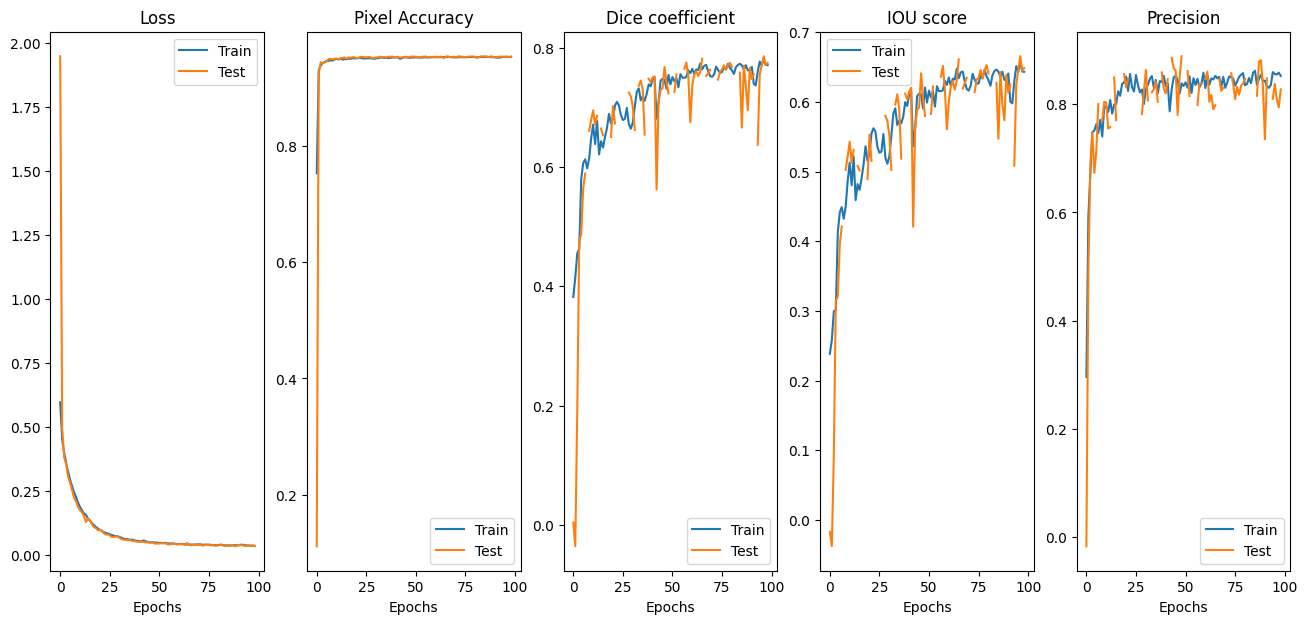

In [ ]:
plot_loss_curves(results_train, results_test)

## ResNet Custom DataSet

In [ ]:
class UAVDataset_ResNet(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB") # multi-channel segmentation

        # using random library to ensure image and mask pairs have the same transformations

        if random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        if random() > 0.8:
            image = TF.rotate(image, 30)
            mask = TF.rotate(mask, 30)

        image = TF.to_tensor(image)
        image = TF.resize(image,size = (572,572))
        mask = TF.to_tensor(mask)
        mask = TF.resize(mask,size = (274,274))
        return image, mask

In [ ]:
os.getcwd()
os.makedirs('/kaggle/working/saved_model', exist_ok = True)

In [ ]:
data1 = UAVDataset_ResNet(img_dir = img_dir, mask_dir = mask_dir)

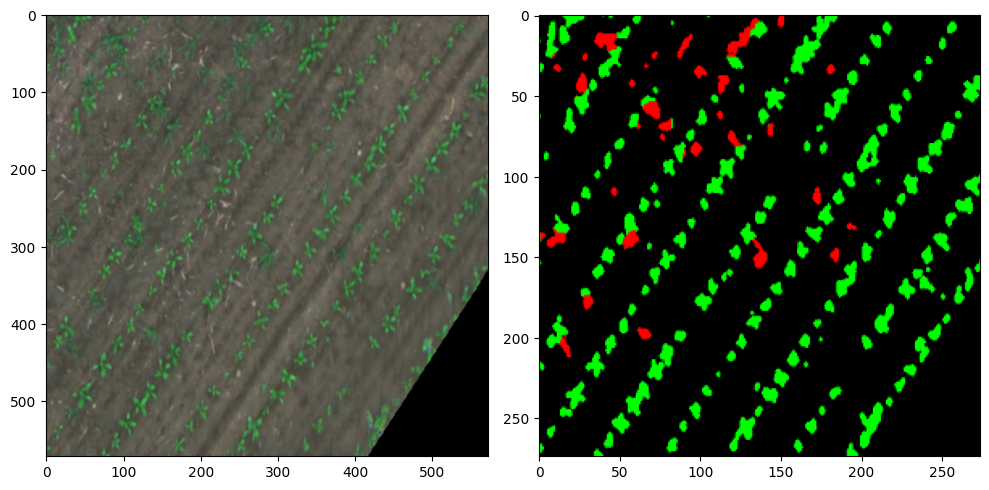

In [ ]:
fig1, ax1 = plt.subplots(1, 2, figsize=(10,5))
image1, mask1 = data1[8]
ax1[0].imshow(image1.permute(1,2,0))
ax1[1].imshow(mask1.permute(1,2,0))
plt.tight_layout()

In [ ]:
print(image1.shape)
print(mask1.shape)

torch.Size([3, 572, 572])
torch.Size([3, 274, 274])


In [ ]:
train_size1 = int(len(data1)*SPLIT)
test_size1 = len(data1) - train_size1

trainData1, testData1 = random_split(data1, [train_size1, test_size1])

In [ ]:
trainDL_res = DataLoader(trainData1, batch_size = 8, shuffle = True)
testDL_res = DataLoader(testData1, batch_size = 8, shuffle = False)

In [ ]:
for batch in trainDL_res:
    img1, mask1 = batch
    print(img1.size())
    print(mask1.size())
    break

torch.Size([8, 3, 572, 572])
torch.Size([8, 3, 274, 274])


In [ ]:
import torch.nn.functional as F

def crop_image(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = target_size - tensor_size
    padding = [0, 0, 0, 0]  # padding values for top, bottom, left, right

    if delta > 0:
        pad_left = delta // 2
        pad_right = delta - pad_left
        padding = [pad_left, pad_right, pad_left, pad_right]

    return F.pad(tensor, padding)

## ResNet Architecture

In [ ]:
class UNet_ResNet(nn.Module):
    def __init__(self):
        super(UNet_ResNet, self).__init__()

        resnet = models.resnet50(pretrained=True)  # Load pre-trained ResNet50

        # Encoder
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder
        self.up_conv_1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder_conv_1 = DoubleConv(2048, 1024)

        self.up_conv_2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder_conv_2 = DoubleConv(1024, 512)

        self.up_conv_3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_conv_3 = DoubleConv(512, 256)

        self.up_conv_4 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.decoder_conv_4 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64,3,kernel_size=1)

    def forward(self, x):
      x1 = self.encoder1(x)
      x2 = self.encoder2(x1)
      x3 = self.encoder3(x2)
      x4 = self.encoder4(x3)
      x5 = self.encoder5(x4)


      # Decoder
      x = self.up_conv_1(x5)
      y = crop_image(x4,x)
      x = self.decoder_conv_1(torch.cat([x,y],1))


      x = self.up_conv_2(x)
      y = crop_image(x,x3)
      x = self.decoder_conv_2(torch.cat([x3,y],1))


      x = self.up_conv_3(x)
      y = crop_image(x,x2)
      x = self.decoder_conv_3(torch.cat([x2,y],1))


      x = self.up_conv_4(x)
      y = crop_image(x1,x)
      x = self.decoder_conv_4(torch.cat([x,y],1))

      x = self.out(x)

      return x

# Define the double convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
# ensure predicted mask & actual mask have equal dimensions
for batch in trainDL_res:
    img, mask = batch
    print(mask.shape)
    break
model_res = UNet_ResNet().to(DEVICE)
x = img1[0].unsqueeze(0).to(DEVICE)
pred = model_res(x)

print(x.shape)
print(pred.shape)

torch.Size([8, 3, 274, 274])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([1, 3, 572, 572])
torch.Size([1, 3, 274, 274])


In [ ]:
summary(model_res, [16, 3, 572, 572])

Layer (type:depth-idx)                   Output Shape              Param #
UNet_ResNet                              [16, 3, 274, 274]         --
├─Sequential: 1-1                        [16, 64, 143, 143]        --
│    └─Conv2d: 2-1                       [16, 64, 286, 286]        9,408
│    └─BatchNorm2d: 2-2                  [16, 64, 286, 286]        128
│    └─ReLU: 2-3                         [16, 64, 286, 286]        --
│    └─MaxPool2d: 2-4                    [16, 64, 143, 143]        --
├─Sequential: 1-2                        [16, 256, 143, 143]       --
│    └─Bottleneck: 2-5                   [16, 256, 143, 143]       --
│    │    └─Conv2d: 3-1                  [16, 64, 143, 143]        4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 143, 143]        128
│    │    └─ReLU: 3-3                    [16, 64, 143, 143]        --
│    │    └─Conv2d: 3-4                  [16, 64, 143, 143]        36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 143, 143]        128
│ 

## Training Loop for ResNet

In [ ]:
loss_criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_res.parameters(), lr=LR)

In [ ]:
trainLossCount_res, testLossCount_res, trainAccCountpixel_res, testAccCountpixel_res, trainAccCountdice_res, testAccCountdice_res, trainAccCountiou_res, testAccCountiou_res, trainAccCountprecision_res, testAccCountprecision_res = train_loop(99, model_res, trainDL_res, testDL_res, optimizer, loss_criteria)

Epoch: 0 ->
Train Loss: 0.565817233763243, Test Loss: 0.6166394948959351
Train Pixel Accuracy: 0.8489225851862054, Test Pixel Accuracy: 0.9577722946802775
Train Dice Coefficient: 0.058736857026815414, Test Dice Coefficient: 0.006666666828095913
Train IOU Score: 0.03194736689329147, Test IOU Score: 0.0035555558279156685
Train Precision: 0.06763157993555069, Test Precision: nan
Saving the model. Previous Best Test Loss: 10000000, Current Test Loss: 0.6166394948959351
Epoch: 1 ->
Train Loss: 0.4691045880317688, Test Loss: 0.48122331500053406
Train Pixel Accuracy: 0.9660945440593519, Test Pixel Accuracy: 0.959922280576494
Train Dice Coefficient: 0.0015263159293681383, Test Dice Coefficient: 0.0035555558279156685
Train IOU Score: 0.0007894737063907087, Test IOU Score: 0.0018888890044763684
Train Precision: 0.024578947573900223, Test Precision: nan
Saving the model. Previous Best Test Loss: 0.6166394948959351, Current Test Loss: 0.48122331500053406
Epoch: 2 ->
Train Loss: 0.423250066606622, 

## Conclusion for ResNet

In [ ]:
trainAccCountpixel_numpy_res, trainAccCountdice_numpy_res, trainAccCountiou_numpy_res, trainAccCountprecision_numpy_res = numpy_conversion_train(trainAccCountpixel_res, trainAccCountdice_res, trainAccCountiou_res, trainAccCountprecision_res)

In [ ]:
testLossCount_numpy_res, testAccCountpixel_numpy_res, testAccCountdice_numpy_res, testAccCountiou_numpy_res, testAccCountprecision_numpy_res = numpy_coversion_test(testLossCount_res, testAccCountpixel_res, testAccCountdice_res, testAccCountiou_res, testAccCountprecision_res)

In [ ]:
results_test_res = {
    "testLossCount": testLossCount_numpy_res,
    "testAccCountpixel": testAccCountpixel_numpy_res,
    "testAccCountdice": testAccCountdice_numpy_res,
    "testAccCountiou": testAccCountiou_numpy_res,
    "testAccCountprecision": testAccCountprecision_numpy_res
}

In [ ]:
results_train_res = {
    "trainLossCount": trainLossCount_res,
    "trainAccCountpixel": trainAccCountpixel_numpy_res,
    "trainAccCountdice": trainAccCountdice_numpy_res,
    "trainAccCountiou": trainAccCountiou_numpy_res,
    "trainAccCountprecision": trainAccCountprecision_numpy_res
}

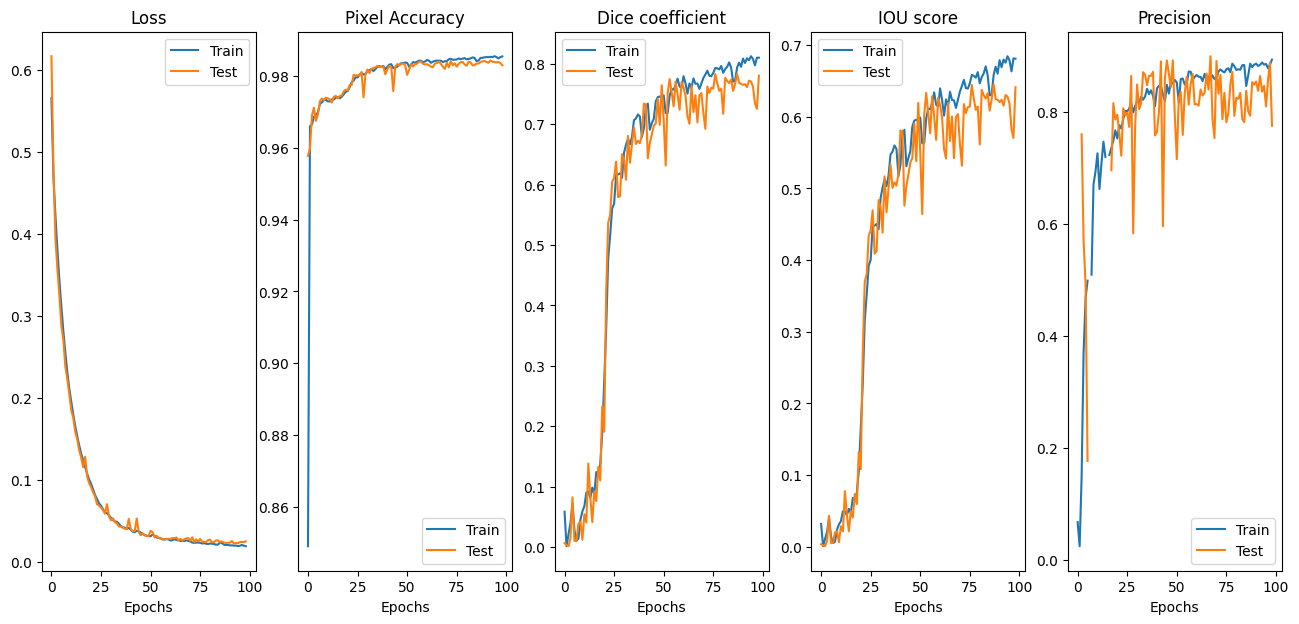

In [ ]:
plot_loss_curves(results_train_res, results_test_res)

## Model Inference

In [ ]:
# # plot test_batch with true / predicted masks

# for batch_idx, (image, true_mask) in enumerate(testDL):

#     image = image.to("cuda")
#     true_mask = true_mask.to("cuda")
#     if batch_idx == 0:
#         fig, axs = plt.subplots(4, 6, figsize = (10,10))
#         axs = axs.flatten()
#         pred_mask = model(image)
#         j = 0
#         for i in range(8):

#             # Plot the image
#             axs[j].imshow(image[i].detach().cpu().numpy().transpose(1,2,0))
#             axs[j].axis('off')
#             axs[j].set_title(f'Image {i+1}')

#             # Plot the predicted mask
#             axs[j+1].imshow(pred_mask[i].detach().cpu().numpy().transpose(1,2,0))
#             axs[j+1].axis('off')
#             axs[j+1].set_title(f'Predicted Mask {i+1}')

#             # Plot the corresponding mask
#             axs[j+2].imshow(true_mask[i].detach().cpu().numpy().transpose(1,2,0))
#             axs[j+2].axis('off')
#             axs[j+2].set_title(f'True Mask {i+1}')
#             j += 3

#         plt.suptitle('Prediction vs True Mask', size = 20)
#         plt.tight_layout()